This notebook is an analysis of Jessica's Li's analysis of our data. It starts as importing her RDS files and then compiling them into data frames of features.   
TJE 2020 10 23.  
  
This notebook has been updated by TJE on 2020 11 19. The new changes now use my coding sequence lengths as a feature, and use Jessica's 3 other features. 

Updated 2021 to include CAI and fixed a bug with respect to how 3' UTR legths were called. 

In [1]:
#imports
library(tidyverse)
library(MASS) #stepwise linear regression
library(boot) #bootstrapping the linear models.
source("/Users/timeisen/ggplot_theme.R") #Home Computer
# source("/Users/timeisen/Documents/LocalAnalysis/ggplot_theme.R") #Work Computer
#Replace timeisen with timeisen to set back to home computer. 
# annot <- read_tsv("/lab/solexa_bartel/timeisen/RNAseq/Annotation_files/TAIL_seq/symbol_to_accession.txt")

#options
options(repr.plot.width=3,repr.plot.height=3)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




log_ticks usage:
labels = log_ticks(start,end)[[1]]
breaks = log_ticks(start,end)[[2]] 


In [2]:
feature_list = c("polyA_lens", 
                 "FE_Mega", 
                 "FP_Mega", 
                 "CO_Mega", 
                 "cds_length.log10", 
                 "uAUG_counts", 
                 "log10.mRNA", 
                 "TpUtrLength.log10", 
                 "FpUtrLength.log10",
                 "FpUtrGC",
                 "CDS_GC",
                 "TpUtrGC",
                 "exon_no",
                 "CDS_AU",
                 "ExonJunctionDensity",
                 "CAI")
# feature_list = c("polyA_lens", 
#                  "FE_Mega", 
#                  "FP_Mega", 
#                  "CO_Mega", 
#                  "cds_length.log10", 
#                  "uAUG_counts", 
#                  "log10.mRNA", 
#                  "TpUtrLength.log10", 
#                  "FpUtrLength.log10")
print(length(feature_list))

[1] 16


In [3]:
CORCUL <- readRDS("mm.CorticalCulture.features.rds")
NEUCOR <- readRDS("mm.NeuronalCortex.features.rds")
KIDNEY <- readRDS("mm.kidney.features.rds")
MLIVER <- readRDS("mm.liver.features.rds")
NIH3T3 <- readRDS("mm.nih3t3.features.rds")

#Convert ensembl to rows.
CORCUL$accession <- rownames(CORCUL) #they're ensembl accessions, but I'm still using the same name
NEUCOR$accession <- rownames(NEUCOR) 
KIDNEY$accession <- rownames(KIDNEY) 
MLIVER$accession <- rownames(MLIVER) 
NIH3T3$accession <- rownames(NIH3T3) 

#Switch to my style TE
CORCUL$TE = CORCUL$log10.TR / log10(2)
NEUCOR$TE = NEUCOR$log10.TR / log10(2)
KIDNEY$TE = KIDNEY$log10.TR / log10(2)
MLIVER$TE = MLIVER$log10.TR / log10(2)
NIH3T3$TE = NIH3T3$log10.TR / log10(2)

CORCUL$log10.TR <- NULL
NEUCOR$log10.TR <- NULL
KIDNEY$log10.TR <- NULL
MLIVER$log10.TR <- NULL
NIH3T3$log10.TR <- NULL

#Tibble, re-naming duplicate columns. 
CORCULT <- tibble(CORCUL, .name_repair = c("unique"))
NEUCORT <- tibble(NEUCOR, .name_repair = c("unique"))
KIDNEYT <- tibble(KIDNEY, .name_repair = c("unique"))
MLIVERT <- tibble(MLIVER, .name_repair = c("unique"))
NIH3T3T <- tibble(NIH3T3, .name_repair = c("unique"))


In [4]:
print(CORCULT, width = Inf)

# A tibble: 3,267 x 96
   uAUG_counts `fe_-1window_6` `fe_25%_6` `fe_sum<=10%_6` `fe_%<=20%_8`
         <int>           <dbl>      <dbl>           <dbl>         <dbl>
 1           6       -4.16e- 4  -0.000668         -0.0933         0.255
 2           2       -1.85e- 4  -0.000573         -0.168          0.262
 3           0       -8.14e- 5  -0.000416         -0.0392         0.202
 4           7       -1.85e- 4  -0.000574         -0.236          0.255
 5           3       -3.10e- 5  -0.000785         -0.0994         0.276
 6           1        1.37e-16  -0.000573         -0.0405         0.308
 7           3       -1.52e- 3  -0.000240         -0.0537         0.148
 8           1       -7.95e- 4  -0.000792         -0.123          0.306
 9           1        1.37e-16  -0.000573         -0.0288         0.327
10           0        1.37e-16  -0.000376         -0.0326         0.207
   `fe_sum<=5%_8` `fe_sum<=10%_8` `fe_sum<=20%_8` `fe_5'mostTICE_10`
            <dbl>           <dbl>           

In [5]:
#adding the cds lengths for everything.
mart <- read_tsv("/Users/timeisen/Dropbox (MIT)/BartelLab/Neurons mRNA tails paper/Analysis/BigginModel/codes_for_120518_version/TJE_Analysis/refseq_to_ensemble_mouse_mart_export20200909.txt") %>%
    dplyr::rename(accession = `RefSeq mRNA ID`) %>%
    dplyr::select(EnsembleG = `Gene stable ID`, EnsembleT = `Transcript stable ID`, accession) %>%
    distinct() 
annot <- read_tsv("/Users/timeisen/Dropbox (MIT)/BartelLab/Neurons mRNA tails paper/Analysis/BigginModel/codes_for_120518_version/TJE_Analysis/symbol_to_accession.txt")
CDS_LENGTHS <- read_tsv("/Users/timeisen/Dropbox (MIT)/BartelLab/Neurons mRNA tails paper/Analysis/ProcessedFiles/mm10_orf_lengths_not_trimmed.txt", col_names = FALSE) %>%
    dplyr::select(accession = X1, length = X2) %>%
    inner_join(annot, by = 'accession') %>%
    print() %>%
    inner_join(mart) %>%
    distinct(accession, .keep_all = TRUE) %>%
    dplyr::select(EnsembleT, EnsembleG, cds_length = length) %>%
    mutate(cds_length.log10 = log10(cds_length)) %>%
    dplyr::select(-cds_length) %>%
    print()
#Note that I lose 20,638 - 20,413 genes by this method but it seems OK for now. 


Parsed with column specification:
cols(
  `Gene stable ID` = col_character(),
  `Gene stable ID version` = col_character(),
  `Transcript stable ID` = col_character(),
  `Transcript stable ID version` = col_character(),
  `RefSeq mRNA ID` = col_character(),
  `RefSeq mRNA predicted ID` = col_character()
)

Parsed with column specification:
cols(
  symbol = col_character(),
  accession = col_character()
)

Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_double()
)



# A tibble: 20,638 x 3
   accession    length symbol
   <chr>         <dbl> <chr> 
 1 NM_016868      1989 Hif3a 
 2 NM_016869      3342 Corin 
 3 NM_001033128   1782 Bbs1  
 4 NM_001033126    753 Cd27  
 5 NM_016863       327 Fkbp1b
 6 NM_016860      1131 Actr1a
 7 NM_016861       984 Pdlim1
 8 NM_016866      1671 Stk39 
 9 NM_016867       945 Gipc2 
10 NM_178874      2121 Tmcc2 
# … with 20,628 more rows


Joining, by = "accession"



# A tibble: 20,423 x 3
   EnsembleT          EnsembleG          cds_length.log10
   <chr>              <chr>                         <dbl>
 1 ENSMUST00000037762 ENSMUSG00000004328             3.30
 2 ENSMUST00000005352 ENSMUSG00000005220             3.52
 3 ENSMUST00000053506 ENSMUSG00000006464             3.25
 4 ENSMUST00000032486 ENSMUSG00000030336             2.88
 5 ENSMUST00000020964 ENSMUSG00000020635             2.51
 6 ENSMUST00000040270 ENSMUSG00000025228             3.05
 7 ENSMUST00000068439 ENSMUSG00000055044             2.99
 8 ENSMUST00000102715 ENSMUSG00000027030             3.22
 9 ENSMUST00000046614 ENSMUSG00000039131             2.98
10 ENSMUST00000045473 ENSMUSG00000042066             3.33
# … with 20,413 more rows


In [6]:
TpUtrLengthsMod = read_tsv("/Users/timeisen/Dropbox (MIT)/BartelLab/Neurons mRNA tails paper/Analysis/TeLinearModel/LightStimPalAnnotations20211019MultiIso_3pUTR_lengths.txt") %>% 
    separate(accession, into = c("accession","chrom_hash"), sep = "::") %>%
    separate(accession, into = c("accession","IsoformNumber","TagFraction"), sep = ":") %>%
    mutate(TagFraction = as.numeric(TagFraction)) %>%
    group_by(accession) %>%
    mutate(WeightedLength = sum(length * TagFraction)) %>%
    ungroup() %>%
    distinct(accession, .keep_all = TRUE) %>%
    dplyr::select(accession = accession, TpUtrLength = WeightedLength) %>%
    inner_join(annot, by = 'accession') %>%
    inner_join(mart) %>%
    distinct(accession, .keep_all = TRUE) %>%
    dplyr::select(EnsembleT, EnsembleG, TpUtrLength) %>%
    mutate(TpUtrLength.log10 = log10(TpUtrLength)) %>%
    dplyr::select(-TpUtrLength)

FpUtrLengths    = read_tsv("/Users/timeisen/Dropbox (MIT)/BartelLab/Neurons mRNA tails paper/Analysis/TeLinearModel/LightStimPalAnnotations20211019_5pUTR_lengths.txt") %>% 
    separate(accession, into = c("accession","chrom_hash"), sep = "::") %>%
    dplyr::select(accession = accession, FpUtrLength = length) %>%
    inner_join(annot, by = 'accession') %>%
    inner_join(mart) %>%
    distinct(accession, .keep_all = TRUE) %>%
    dplyr::select(EnsembleT, EnsembleG, FpUtrLength) %>%
     mutate(FpUtrLength.log10 = log10(FpUtrLength)) %>%
    dplyr::select(-FpUtrLength)

Parsed with column specification:
cols(
  accession = col_character(),
  length = col_double()
)

Joining, by = "accession"

Parsed with column specification:
cols(
  accession = col_character(),
  length = col_double()
)

Joining, by = "accession"



In [7]:
#GC content
FpUtrGC    = read_tsv("/Users/timeisen/Dropbox (MIT)/BartelLab/Neurons mRNA tails paper/Analysis/TeLinearModel/LightStimPalAnnotations20211019_5pUTR_GCcontent.txt") %>% 
    separate(accession, into = c("accession","chrom_hash"), sep = "::") %>%
    dplyr::select(accession = accession, FpUtrGC = GC_fraction) %>%
    inner_join(annot, by = 'accession') %>%
    inner_join(mart) %>%
    distinct(accession, .keep_all = TRUE) %>%
    dplyr::select(EnsembleT, EnsembleG, FpUtrGC)

#GC content
CDS_GC    = read_tsv("/Users/timeisen/Dropbox (MIT)/BartelLab/Neurons mRNA tails paper/Analysis/TeLinearModel/LightStimPalAnnotations20211019_CDS_GCcontent.txt") %>% 
    separate(accession, into = c("accession","chrom_hash"), sep = "::") %>%
    dplyr::select(accession = accession, CDS_GC = GC_fraction) %>%
    inner_join(annot, by = 'accession') %>%
    inner_join(mart) %>%
    distinct(accession, .keep_all = TRUE) %>%
    dplyr::select(EnsembleT, EnsembleG, CDS_GC)

TpUtrGC    = read_tsv("/Users/timeisen/Dropbox (MIT)/BartelLab/Neurons mRNA tails paper/Analysis/TeLinearModel/LightStimPalAnnotations20211019_3pUTR_GCcontent.txt") %>% 
    separate(accession, into = c("accession","chrom_hash"), sep = "::") %>%
    dplyr::select(accession = accession, TpUtrGC = GC_fraction) %>%
    inner_join(annot, by = 'accession') %>%
    inner_join(mart) %>%
    distinct(accession, .keep_all = TRUE) %>%
    dplyr::select(EnsembleT, EnsembleG, TpUtrGC)

#CDS CAI
CDS_CAI    = read_tsv("/Users/timeisen/Dropbox (MIT)/BartelLab/Neurons mRNA tails paper/Analysis/TeLinearModel/LightStimPalAnnotations20211019_CDS_CAI.txt") %>% 
    separate(accession, into = c("accession","chrom_hash"), sep = "::") %>%
    dplyr::select(accession = accession, CAI) %>%
    inner_join(annot, by = 'accession') %>%
    inner_join(mart) %>%
    distinct(accession, .keep_all = TRUE) %>%
    dplyr::select(EnsembleT, EnsembleG, CAI)


Parsed with column specification:
cols(
  accession = col_character(),
  GC_counts = col_double(),
  GC_fraction = col_double()
)

Joining, by = "accession"

Parsed with column specification:
cols(
  accession = col_character(),
  GC_counts = col_double(),
  GC_fraction = col_double()
)

Joining, by = "accession"

Parsed with column specification:
cols(
  accession = col_character(),
  GC_counts = col_double(),
  GC_fraction = col_double()
)

Joining, by = "accession"

Parsed with column specification:
cols(
  accession = col_character(),
  CAI = col_double()
)

Joining, by = "accession"



In [8]:
#exon no
CDS_ExonNo <- read_tsv("/Users/timeisen/Dropbox (MIT)/BartelLab/Neurons mRNA tails paper/Analysis/TeLinearModel/AdditionalFeatures20210113/LightStimPalAnnotations20200106_CDS_ExonNo.txt", col_names = FALSE) %>%
    dplyr::select(accession = X1, exon_no = X2) %>%
    inner_join(annot, by = 'accession') %>%
    inner_join(mart) %>%
    distinct(accession, .keep_all = TRUE) %>%
    dplyr::select(EnsembleT, EnsembleG, exon_no) 

#ARE elements, note that these are using the 20200130 annot. 
CDS_AU <- read_tsv("/Users/timeisen/Dropbox (MIT)/BartelLab/Neurons mRNA tails paper/Analysis/TeLinearModel/LightStimPalAnnotations20211019_CDS_AUelements.txt") %>% 
    separate(accession, into = c("accession","chrom_hash"), sep = "::") %>%
    dplyr::select(accession = accession, CDS_AU = numAUElements) %>%
    inner_join(annot, by = 'accession') %>%
    inner_join(mart) %>%
    distinct(accession, .keep_all = TRUE) %>%
    dplyr::select(EnsembleT, EnsembleG, CDS_AU)


Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_double()
)

Joining, by = "accession"

Parsed with column specification:
cols(
  accession = col_character(),
  AU_PentamerCount = col_double(),
  numAUElements = col_double(),
  aurichFraction = col_double(),
  longestAUElement = col_double()
)

Joining, by = "accession"



In [9]:
CodonFrequencies <- read_tsv("/Users/timeisen/Dropbox (MIT)/BartelLab/Neurons mRNA tails paper/Analysis/TeLinearModel/LightStimPalAnnotations20211019_CDS_CodonFrequencies.txt") %>% 
    rename(accession = Gene_name) %>%
    separate(accession, into = c("accession","chrom_hash"), sep = "::") %>%
    dplyr::select(-chrom_hash)

CodonTable <- read_delim("/Users/timeisen/Dropbox (MIT)/BartelLab/Neurons mRNA tails paper/Analysis/TeLinearModel/CodonTable.txt", delim = "=", col_names = FALSE) %>%
    mutate(X1 = str_trim(X1), X2 = str_trim(X2)) %>% #removes whitespace 
    mutate(X2 = gsub("'", "", X2)) %>% #why doesn't str_replace work?
    dplyr::select(aa = X1, codon = X2)

ColTibble <- tibble(codon = colnames(CodonFrequencies)[-1]) %>% 
    left_join(CodonTable, by = 'codon') %>%
    unite(codon, codon, aa)

colnames(CodonFrequencies)[-1] <- ColTibble$codon
CodonFrequencies <- inner_join(CodonFrequencies, mart, by = 'accession') %>%
    distinct(accession, .keep_all = TRUE)
colnames(CodonFrequencies)[2:65] = paste("codon_", colnames(CodonFrequencies)[2:65])
CodonFrequencies <- CodonFrequencies %>% dplyr::select(-accession)




Parsed with column specification:
cols(
  .default = col_double(),
  Gene_name = col_character()
)

See spec(...) for full column specifications.

Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_character()
)



In [10]:
#This replaces Jessica's codon frequencies with mine.
CORCULT <- CORCULT[,-str_which(colnames(CORCULT), "codon_")] %>% inner_join(dplyr::rename(CodonFrequencies, accession = EnsembleG), by = 'accession') %>% dplyr::select(-EnsembleT)
NEUCORT <- NEUCORT[,-str_which(colnames(NEUCORT), "codon_")] %>% inner_join(dplyr::rename(CodonFrequencies, accession = EnsembleG), by = 'accession') %>% dplyr::select(-EnsembleT)
KIDNEYT <- KIDNEYT[,-str_which(colnames(KIDNEYT), "codon_")] %>% inner_join(dplyr::rename(CodonFrequencies, accession = EnsembleG), by = 'accession') %>% dplyr::select(-EnsembleT)
MLIVERT <- MLIVERT[,-str_which(colnames(MLIVERT), "codon_")] %>% inner_join(dplyr::rename(CodonFrequencies, accession = EnsembleG), by = 'accession') %>% dplyr::select(-EnsembleT)
NIH3T3T <- NIH3T3T[,-str_which(colnames(NIH3T3T), "codon_")] %>% inner_join(dplyr::rename(CodonFrequencies, accession = EnsembleT), by = 'accession') %>% dplyr::select(-EnsembleG)

In [11]:
#add expression to each dataset. 
CorCultInput <- readRDS("/Users/timeisen/Dropbox (MIT)/BartelLab/Neurons mRNA tails paper/Analysis/BigginModel/codes_for_120518_version/ModelingInputData/CorticalCultureData.rds")
CorCultInput <- dplyr::select(CorCultInput, accession = Ensembl, `log10 mRNA`)
CORCULT <- inner_join(CORCULT, CorCultInput, by = "accession") %>%
    rename(log10.mRNA = `log10 mRNA`)


NeurCorInput <- readRDS("/Users/timeisen/Dropbox (MIT)/BartelLab/Neurons mRNA tails paper/Analysis/BigginModel/codes_for_120518_version/ModelingInputData/NeuronalCortexData.rds")
NeurCorInput <- dplyr::select(NeurCorInput, accession = Ensembl, `log10 mRNA`)
NEUCORT <- inner_join(NEUCORT, NeurCorInput, by = "accession") %>%
    rename(log10.mRNA = `log10 mRNA`)

In [12]:
#add my CDS lengths here
CORCULT <- inner_join(CORCULT, dplyr::select(CDS_LENGTHS, accession = EnsembleG, cds_length.log10), by = 'accession') %>% dplyr::select(-log10.CDS_lens)
NEUCORT <- inner_join(NEUCORT, dplyr::select(CDS_LENGTHS, accession = EnsembleG, cds_length.log10), by = 'accession') %>% dplyr::select(-log10.CDS_lens)
KIDNEYT <- inner_join(KIDNEYT, dplyr::select(CDS_LENGTHS, accession = EnsembleG, cds_length.log10), by = 'accession') %>% dplyr::select(-log10.CDS_lens)
MLIVERT <- inner_join(MLIVERT, dplyr::select(CDS_LENGTHS, accession = EnsembleG, cds_length.log10), by = 'accession') %>% dplyr::select(-log10.CDS_lens)
NIH3T3T <- inner_join(NIH3T3T, dplyr::select(CDS_LENGTHS, accession = EnsembleT, cds_length.log10), by = 'accession') %>% dplyr::select(-log10.CDS_lens)

In [13]:
#adds in the UTR lengths
CORCULT <- inner_join(CORCULT, dplyr::select(TpUtrLengthsMod, accession = EnsembleG, TpUtrLength.log10), by = 'accession')
NEUCORT <- inner_join(NEUCORT, dplyr::select(TpUtrLengthsMod, accession = EnsembleG, TpUtrLength.log10), by = 'accession')
KIDNEYT <- inner_join(KIDNEYT, dplyr::select(TpUtrLengthsMod, accession = EnsembleG, TpUtrLength.log10), by = 'accession')
MLIVERT <- inner_join(MLIVERT, dplyr::select(TpUtrLengthsMod, accession = EnsembleG, TpUtrLength.log10), by = 'accession')
NIH3T3T <- inner_join(NIH3T3T, dplyr::select(TpUtrLengthsMod, accession = EnsembleT, TpUtrLength.log10), by = 'accession')

#adds in the UTR lengths
CORCULT <- inner_join(CORCULT, dplyr::select(FpUtrLengths, accession = EnsembleG, FpUtrLength.log10), by = 'accession')
NEUCORT <- inner_join(NEUCORT, dplyr::select(FpUtrLengths, accession = EnsembleG, FpUtrLength.log10), by = 'accession')
KIDNEYT <- inner_join(KIDNEYT, dplyr::select(FpUtrLengths, accession = EnsembleG, FpUtrLength.log10), by = 'accession')
MLIVERT <- inner_join(MLIVERT, dplyr::select(FpUtrLengths, accession = EnsembleG, FpUtrLength.log10), by = 'accession')
NIH3T3T <- inner_join(NIH3T3T, dplyr::select(FpUtrLengths, accession = EnsembleT, FpUtrLength.log10), by = 'accession')

In [14]:
#adds in the 5pUTR GC
CORCULT <- inner_join(CORCULT, dplyr::select(FpUtrGC, accession = EnsembleG, FpUtrGC), by = 'accession')
NEUCORT <- inner_join(NEUCORT, dplyr::select(FpUtrGC, accession = EnsembleG, FpUtrGC), by = 'accession')
KIDNEYT <- inner_join(KIDNEYT, dplyr::select(FpUtrGC, accession = EnsembleG, FpUtrGC), by = 'accession')
MLIVERT <- inner_join(MLIVERT, dplyr::select(FpUtrGC, accession = EnsembleG, FpUtrGC), by = 'accession')
NIH3T3T <- inner_join(NIH3T3T, dplyr::select(FpUtrGC, accession = EnsembleT, FpUtrGC), by = 'accession')

#Adds in CDS GC
CORCULT <- inner_join(CORCULT, dplyr::select(CDS_GC, accession = EnsembleG, CDS_GC), by = 'accession')
NEUCORT <- inner_join(NEUCORT, dplyr::select(CDS_GC, accession = EnsembleG, CDS_GC), by = 'accession')
KIDNEYT <- inner_join(KIDNEYT, dplyr::select(CDS_GC, accession = EnsembleG, CDS_GC), by = 'accession')
MLIVERT <- inner_join(MLIVERT, dplyr::select(CDS_GC, accession = EnsembleG, CDS_GC), by = 'accession')
NIH3T3T <- inner_join(NIH3T3T, dplyr::select(CDS_GC, accession = EnsembleT, CDS_GC), by = 'accession')

#adds in the TpUTR GC
CORCULT <- inner_join(CORCULT, dplyr::select(TpUtrGC, accession = EnsembleG, TpUtrGC), by = 'accession')
NEUCORT <- inner_join(NEUCORT, dplyr::select(TpUtrGC, accession = EnsembleG, TpUtrGC), by = 'accession')
KIDNEYT <- inner_join(KIDNEYT, dplyr::select(TpUtrGC, accession = EnsembleG, TpUtrGC), by = 'accession')
MLIVERT <- inner_join(MLIVERT, dplyr::select(TpUtrGC, accession = EnsembleG, TpUtrGC), by = 'accession')
NIH3T3T <- inner_join(NIH3T3T, dplyr::select(TpUtrGC, accession = EnsembleT, TpUtrGC), by = 'accession')


In [15]:
#Adds in CDS exon no
CORCULT <- inner_join(CORCULT, dplyr::select(CDS_ExonNo, accession = EnsembleG, exon_no), by = 'accession')
NEUCORT <- inner_join(NEUCORT, dplyr::select(CDS_ExonNo, accession = EnsembleG, exon_no), by = 'accession')
KIDNEYT <- inner_join(KIDNEYT, dplyr::select(CDS_ExonNo, accession = EnsembleG, exon_no), by = 'accession')
MLIVERT <- inner_join(MLIVERT, dplyr::select(CDS_ExonNo, accession = EnsembleG, exon_no), by = 'accession')
NIH3T3T <- inner_join(NIH3T3T, dplyr::select(CDS_ExonNo, accession = EnsembleT, exon_no), by = 'accession')

#Adds in CDS AU elements
CORCULT <- inner_join(CORCULT, dplyr::select(CDS_AU, accession = EnsembleG, CDS_AU), by = 'accession')
NEUCORT <- inner_join(NEUCORT, dplyr::select(CDS_AU, accession = EnsembleG, CDS_AU), by = 'accession')
KIDNEYT <- inner_join(KIDNEYT, dplyr::select(CDS_AU, accession = EnsembleG, CDS_AU), by = 'accession')
MLIVERT <- inner_join(MLIVERT, dplyr::select(CDS_AU, accession = EnsembleG, CDS_AU), by = 'accession')
NIH3T3T <- inner_join(NIH3T3T, dplyr::select(CDS_AU, accession = EnsembleT, CDS_AU), by = 'accession')

#Adds in CDS CAI
CORCULT <- inner_join(CORCULT, dplyr::select(CDS_CAI, accession = EnsembleG, CAI), by = 'accession')
NEUCORT <- inner_join(NEUCORT, dplyr::select(CDS_CAI, accession = EnsembleG, CAI), by = 'accession')
KIDNEYT <- inner_join(KIDNEYT, dplyr::select(CDS_CAI, accession = EnsembleG, CAI), by = 'accession')
MLIVERT <- inner_join(MLIVERT, dplyr::select(CDS_CAI, accession = EnsembleG, CAI), by = 'accession')
NIH3T3T <- inner_join(NIH3T3T, dplyr::select(CDS_CAI, accession = EnsembleT, CAI), by = 'accession')


In [16]:
#create the exon junction density feature
CORCULT <- mutate(CORCULT, ExonJunctionDensity = (exon_no - 1)/ 10^cds_length.log10 * 1000) 
NEUCORT <- mutate(NEUCORT, ExonJunctionDensity = (exon_no - 1)/ 10^cds_length.log10 * 1000) 
KIDNEYT <- mutate(KIDNEYT, ExonJunctionDensity = (exon_no - 1)/ 10^cds_length.log10 * 1000) 
MLIVERT <- mutate(MLIVERT, ExonJunctionDensity = (exon_no - 1)/ 10^cds_length.log10 * 1000) 
NIH3T3T <- mutate(NIH3T3T, ExonJunctionDensity = (exon_no - 1)/ 10^cds_length.log10 * 1000) 

In [17]:
##KEY: REMOVE DUPLICATE ACCESSION
CORCULT <- distinct(CORCULT, accession, .keep_all = TRUE)
NEUCORT <- distinct(NEUCORT, accession, .keep_all = TRUE)
KIDNEYT <- distinct(KIDNEYT, accession, .keep_all = TRUE)
MLIVERT <- distinct(MLIVERT, accession, .keep_all = TRUE)
NIH3T3T <- distinct(NIH3T3T, accession, .keep_all = TRUE)

print(nrow(CORCULT))
print(nrow(NEUCORT))
print(nrow(KIDNEYT))
print(nrow(MLIVERT))
print(nrow(NIH3T3T))

print(CORCULT, width = Inf)

[1] 3252
[1] 2280
[1] 6650
[1] 6210
[1] 6113
# A tibble: 3,252 x 110
   uAUG_counts `fe_-1window_6` `fe_25%_6` `fe_sum<=10%_6` `fe_%<=20%_8`
         <int>           <dbl>      <dbl>           <dbl>         <dbl>
 1           6       -4.16e- 4  -0.000668         -0.0933         0.255
 2           2       -1.85e- 4  -0.000573         -0.168          0.262
 3           0       -8.14e- 5  -0.000416         -0.0392         0.202
 4           7       -1.85e- 4  -0.000574         -0.236          0.255
 5           3       -3.10e- 5  -0.000785         -0.0994         0.276
 6           1        1.37e-16  -0.000573         -0.0405         0.308
 7           3       -1.52e- 3  -0.000240         -0.0537         0.148
 8           1       -7.95e- 4  -0.000792         -0.123          0.306
 9           1        1.37e-16  -0.000573         -0.0288         0.327
10           0        1.37e-16  -0.000376         -0.0326         0.207
   `fe_sum<=5%_8` `fe_sum<=10%_8` `fe_sum<=20%_8` `fe_5'mostTICE_10

In [18]:
# annot <- read_tsv("/Users/timeisen/Dropbox (MIT)/BartelLab/Neurons mRNA tails paper/Analysis/BigginModel/codes_for_120518_version/TJE_Analysis/MM_ultimate_metadata_table_complete.txt") %>%
#     rename(accession = gene_id_short)
annot <- read_tsv("/Users/timeisen/Dropbox (MIT)/BartelLab/Neurons mRNA tails paper/Analysis/BigginModel/codes_for_120518_version/TJE_Analysis/refseq_to_ensemble_mouse_mart_export20200909.txt") %>%
    rename(accession = `Transcript stable ID`, `RefSeq_ID` = `RefSeq mRNA ID`)

mrna <- read_tsv("/Users/timeisen/Dropbox (MIT)/BartelLab/Neurons mRNA tails paper/Analysis/LiteratureData/Subtelny2014/GSE52809_3T3.txt", skip = 2) %>%
    rename(RefSeq_ID = `Transcript ID` ) %>%
    inner_join(annot, by = 'RefSeq_ID')

#for the other datasets
load("/Users/timeisen/Dropbox (MIT)/BartelLab/Neurons mRNA tails paper/Analysis/BigginModel/codes_for_120518_version/processed_data_w_polyA/mm.kidney.Rdata")
load("/Users/timeisen/Dropbox (MIT)/BartelLab/Neurons mRNA tails paper/Analysis/BigginModel/codes_for_120518_version/processed_data_w_polyA/mm.liver.Rdata")
load("/Users/timeisen/Dropbox (MIT)/BartelLab/Neurons mRNA tails paper/Analysis/BigginModel/codes_for_120518_version/processed_data_w_polyA/mm.nih3t3.Rdata")

# print(head(mm.kidney.log10.mRNA))
# print(head(mm.liver.log10.mRNA))
# print(head(mm.nih3t3.log10.mRNA))

KIDNEYT$log10.mRNA <- mm.kidney.log10.mRNA[KIDNEYT$accession]
MLIVERT$log10.mRNA <- mm.liver.log10.mRNA[MLIVERT$accession]
NIH3T3T$log10.mRNA <- mm.nih3t3.log10.mRNA[NIH3T3T$accession]
print(mrna, width = Inf)
NIH3T3TEST <- NIH3T3T %>% inner_join(dplyr::select(mrna, accession, `Poly(A) tags`), by = 'accession')                 
cor(NIH3T3TEST$log10.mRNA, NIH3T3TEST$`Poly(A) tags`, method = "spearman")
# NIH3T3T <- NIH3T3TEST 
#update I need to do more work on the expression parameter. 


Parsed with column specification:
cols(
  `Gene stable ID` = col_character(),
  `Gene stable ID version` = col_character(),
  `Transcript stable ID` = col_character(),
  `Transcript stable ID version` = col_character(),
  `RefSeq mRNA ID` = col_character(),
  `RefSeq mRNA predicted ID` = col_character()
)

Parsed with column specification:
cols(
  `Transcript ID` = col_character(),
  `Gene name` = col_character(),
  `Poly(A) tags` = col_double(),
  `Mean TL` = col_double(),
  `Median TL` = col_double(),
  `10th %ile, TL` = col_double(),
  `25th %ile, TL` = col_double(),
  `75th %ile, TL` = col_double(),
  `90th %ile, TL` = col_double(),
  `mRNA RPKM` = col_double(),
  `RPF RPKM` = col_double(),
  `log2(TE)` = col_double()
)



# A tibble: 19,107 x 17
   RefSeq_ID    `Gene name` `Poly(A) tags` `Mean TL` `Median TL` `10th %ile, TL`
   <chr>        <chr>                <dbl>     <dbl>       <dbl>           <dbl>
 1 NM_001033128 Bbs1                     3      122.       122.             NA  
 2 NM_016862    Vti1a                   60      121.       109              39  
 3 NM_016863    Fkbp1b                   6      127.       121.             NA  
 4 NM_016860    Actr1a                 145      108         97.3            41.3
 5 NM_016861    Pdlim1                   1      159.       159.             NA  
 6 NM_016866    Stk39                  129      109.        88.1            24  
 7 NM_016866    Stk39                  129      109.        88.1            24  
 8 NM_016866    Stk39                  129      109.        88.1            24  
 9 NM_016866    Stk39                  129      109.        88.1            24  
10 NM_016866    Stk39                  129      109.        88.1            24  
   `

[1] 0.7250987

In [19]:
print(nrow(CORCULT))
print(nrow(NEUCORT))
print(nrow(KIDNEYT))
print(nrow(MLIVERT))
print(nrow(NIH3T3T))

print(nrow(CORCULT %>% drop_na()))
print(nrow(NEUCORT %>% drop_na()) )
print(nrow(KIDNEYT %>% drop_na()) )
print(nrow(MLIVERT %>% drop_na()) )
print(nrow(NIH3T3T %>% drop_na()) )

[1] 3252
[1] 2280
[1] 6650
[1] 6210
[1] 6113
[1] 3252
[1] 2280
[1] 6650
[1] 6210
[1] 6113


In [20]:
#little models
CORCULT_FE <- CORCULT[,str_which(colnames(CORCULT), "TE|fe_")]
NEUCORT_FE <- NEUCORT[,str_which(colnames(NEUCORT), "TE|fe_")]
KIDNEYT_FE <- KIDNEYT[,str_which(colnames(KIDNEYT), "TE|fe_")]
MLIVERT_FE <- MLIVERT[,str_which(colnames(MLIVERT), "TE|fe_")]
NIH3T3T_FE <- NIH3T3T[,str_which(colnames(NIH3T3T), "TE|fe_")]

CORCULT_FP <- CORCULT[,str_which(colnames(CORCULT), "TE|5'motif_")]
NEUCORT_FP <- NEUCORT[,str_which(colnames(NEUCORT), "TE|5'motif_")]
KIDNEYT_FP <- KIDNEYT[,str_which(colnames(KIDNEYT), "TE|5'motif_")]
MLIVERT_FP <- MLIVERT[,str_which(colnames(MLIVERT), "TE|5'motif_")]
NIH3T3T_FP <- NIH3T3T[,str_which(colnames(NIH3T3T), "TE|5'motif_")]

CORCULT_CO <- CORCULT[,str_which(colnames(CORCULT), "TE|codon_")] %>% dplyr::select(-`codon_ TGA_Stp1`, -`codon_ TAG_Stp2`, -`codon_ TAA_Stp3`)
NEUCORT_CO <- NEUCORT[,str_which(colnames(NEUCORT), "TE|codon_")] %>% dplyr::select(-`codon_ TGA_Stp1`, -`codon_ TAG_Stp2`, -`codon_ TAA_Stp3`)
KIDNEYT_CO <- KIDNEYT[,str_which(colnames(KIDNEYT), "TE|codon_")] %>% dplyr::select(-`codon_ TGA_Stp1`, -`codon_ TAG_Stp2`, -`codon_ TAA_Stp3`)
MLIVERT_CO <- MLIVERT[,str_which(colnames(MLIVERT), "TE|codon_")] %>% dplyr::select(-`codon_ TGA_Stp1`, -`codon_ TAG_Stp2`, -`codon_ TAA_Stp3`)
NIH3T3T_CO <- NIH3T3T[,str_which(colnames(NIH3T3T), "TE|codon_")] %>% dplyr::select(-`codon_ TGA_Stp1`, -`codon_ TAG_Stp2`, -`codon_ TAA_Stp3`)

In [21]:
#A function to compute the mini-model multivariate predictive coef for each gene
MegaFeatures <- function(MODEL){
    lm.test <- lm(TE ~ ., data = MODEL)
    lm.coef <- lm.test$coefficients
    MODEL = mutate(MODEL, MEGA = apply(dplyr::select(MODEL, -TE), 1, function(x){
    sum(x * lm.coef[-1]) + lm.coef[1]
    }
         )
              )
    return(MODEL)
}

In [22]:
#build each little model, and generate coefficients for each feature within it.
CORCULT_FE_MEGA <- MegaFeatures(CORCULT_FE)
NEUCORT_FE_MEGA <- MegaFeatures(NEUCORT_FE)
KIDNEYT_FE_MEGA <- MegaFeatures(KIDNEYT_FE)
MLIVERT_FE_MEGA <- MegaFeatures(MLIVERT_FE)
NIH3T3T_FE_MEGA <- MegaFeatures(NIH3T3T_FE)
CORCULT_FP_MEGA <- MegaFeatures(CORCULT_FP)
NEUCORT_FP_MEGA <- MegaFeatures(NEUCORT_FP)
KIDNEYT_FP_MEGA <- MegaFeatures(KIDNEYT_FP)
MLIVERT_FP_MEGA <- MegaFeatures(MLIVERT_FP)
NIH3T3T_FP_MEGA <- MegaFeatures(NIH3T3T_FP)
CORCULT_CO_MEGA <- MegaFeatures(CORCULT_CO)
NEUCORT_CO_MEGA <- MegaFeatures(NEUCORT_CO)
KIDNEYT_CO_MEGA <- MegaFeatures(KIDNEYT_CO)
MLIVERT_CO_MEGA <- MegaFeatures(MLIVERT_CO)
NIH3T3T_CO_MEGA <- MegaFeatures(NIH3T3T_CO)

CORCULT_MEGA <- CORCULT %>%
    mutate(FE_Mega = CORCULT_FE_MEGA$MEGA,
           FP_Mega = CORCULT_FP_MEGA$MEGA,
           CO_Mega = CORCULT_CO_MEGA$MEGA) %>%
        dplyr::select(accession, TE, feature_list)

NEUCORT_MEGA <- NEUCORT %>%
    mutate(FE_Mega = NEUCORT_FE_MEGA$MEGA,
           FP_Mega = NEUCORT_FP_MEGA$MEGA,
           CO_Mega = NEUCORT_CO_MEGA$MEGA) %>%
        dplyr::select(accession, TE, feature_list)

KIDNEYT_MEGA <- KIDNEYT %>%
    mutate(FE_Mega = KIDNEYT_FE_MEGA$MEGA,
           FP_Mega = KIDNEYT_FP_MEGA$MEGA,
           CO_Mega = KIDNEYT_CO_MEGA$MEGA) %>%
        dplyr::select(accession, TE, feature_list)

MLIVERT_MEGA <- MLIVERT %>%
    mutate(FE_Mega = MLIVERT_FE_MEGA$MEGA,
           FP_Mega = MLIVERT_FP_MEGA$MEGA,
           CO_Mega = MLIVERT_CO_MEGA$MEGA) %>%
        dplyr::select(accession, TE, feature_list)

NIH3T3T_MEGA <- NIH3T3T %>%
    mutate(FE_Mega = NIH3T3T_FE_MEGA$MEGA,
           FP_Mega = NIH3T3T_FP_MEGA$MEGA,
           CO_Mega = NIH3T3T_CO_MEGA$MEGA) %>%
        dplyr::select(accession, TE, feature_list)



Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(feature_list)` instead of `feature_list` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.



In [23]:
#Creates a list of features
FeatureList <- function(.data, df_name, print, writeTable = FALSE, ...){
    CorrelationMatrix <- .data %>% 
        dplyr::select(-accession, -TE) %>%
        cor(.)
    ClusteredMatrix <- hclust(dist(CorrelationMatrix^2)) #distances of the absolute values. 
    Clusters <- cutree(ClusteredMatrix, k = ncol(.data) - 2)
    CorrelationTibble <- .data %>% 
        dplyr::select(-accession) %>%
        cor(.) %>%
        as_tibble() %>%
        mutate(features = colnames(.)) %>%
        dplyr::select(TE, features) %>%
        full_join(tibble(features = names(Clusters), ClusterNo = Clusters), by = 'features') %>%
        full_join(tibble(features = colnames(CorrelationMatrix), CorIndex = 1:length(colnames(CorrelationMatrix))), by = 'features') %>%
        mutate(Rsq = TE^2) %>%
        group_by(ClusterNo) %>%
        mutate(MaxRsq = max(Rsq),
               MaxFeature = CorIndex[which.max(Rsq)])    
        CorrelationTibble$WithinGroupRsq <- apply(CorrelationTibble[,c(4,7)], 1, function(row){CorrelationMatrix[row[1], row[2]]})

        CorrelationTibble <- ungroup(CorrelationTibble) %>%
        drop_na() %>%
        arrange(desc(MaxRsq), desc(Rsq)) %>%
        mutate(signRsq = ifelse(TE > 0, '+     ', '-     ')) %>%
        dplyr::select(features, ClusterNo, WithinGroupRsq, Rsq, signRsq)
    if(print){print(dplyr::select(CorrelationTibble, -ClusterNo, -WithinGroupRsq), width = Inf, n = Inf)}
    if(writeTable){
    kbl(dplyr::select(CorrelationTibble, -ClusterNo, -WithinGroupRsq)) %>% 
          kable_classic(full_width = F, html_font = "Courier") %>%
        save_kable(paste0('/Users/timeisen/Dropbox (MIT)/BartelLab/Neurons mRNA tails paper/Analysis/FiguresUpdated20210913/ModelFigs/p4_09_Features_',df_name,"_kbl.html"), zoom = 2)
        }
    return(CorrelationTibble)
    }
#Creates a list of features from the megafeature list
FeatureListMega <- function(.data, features, ...){
    features_mod = features
    features_mod[which(features_mod == 'CO_Mega')] = "codon_"
    features_mod[which(features_mod == 'FP_Mega')] = "5'motif_"
    features_mod[which(features_mod == 'FE_Mega')] = "fe_"
    coln = colnames(.data)
    features_final = NULL
    for(nomen in features_mod){
        features_final[[nomen]] = coln[grep(nomen, coln)]
    }
    
    return(features_final)
}

corrplot 0.84 loaded



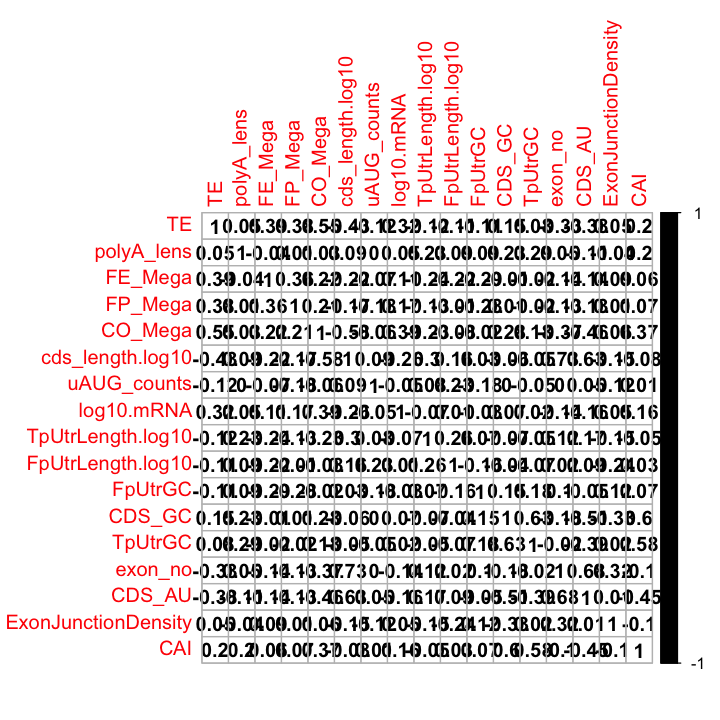

In [24]:
#Trying to figure out why expression matters so little for the NIH3T3 dataset. 
options(repr.plot.width = 6, repr.plot.height = 6)

library(corrplot)
# summary(lm(TE ~ ., dplyr::select(NIH3T3T, -accession)))
corrplot(cor(dplyr::select(NEUCORT_MEGA, -accession), method = 'pearson'), method = "number", col = 'black') # Display the correlation coefficient


In [25]:
GenCumulativeModel <- function(MEGA_DF, FULL_DF, df_name, nrep = 5, AIC = FALSE, print = FALSE, writeTable = FALSE){

    all_features = NULL
    RsqList <- NULL
    Rsq05th <- NULL
    Rsq95th <- NULL
    
    ### creates a list of features###
    CorrelationTibble <- FeatureList(MEGA_DF, df_name, print, writeTable = writeTable)
    features <- CorrelationTibble$features
    if(AIC){features <- GenAIC(MEGA_DF)}
    #Get the order of the features first from the mega dataset
    megafeatures <- FeatureListMega(FULL_DF, features)
    #################################
    
#     summary(lm(TE ~ ., dplyr::select(MEGA_DF, -accession)))$adj.r.squared
#     summary(lm(TE ~ ., dplyr::select(FULL_DF, -accession)))$adj.r.squared
#     summary(lm(TE ~ ., dplyr::select(FULL_DF, -accession, -polyA_lens)))$adj.r.squared
    
    #Iteratively add a feature, with bootstrapping. 
    counter = 1
    RsqFn = function(data, indices){
                summary(lm(TE ~ ., data[indices,]))$adj.r.squared}   
    #original method
#     for (SingleFeature in megafeatures){
#         singleFeatureName = names(megafeatures[counter])
#         all_features <- c(all_features, SingleFeature)
#         dataset = dplyr::select(FULL_DF, TE, all_features)
#         dataset_r = dataset[sample(1:nrow(dataset), nrow(dataset)),] #randomizing the row order. 
#         BoostrapRsq <- boot(dataset_r, statistic = RsqFn, R = 10, parallel= "multicore", ncpus = 1, sim = "ordinary") #Bootstrap it, how many times?
#                             #Note that as this R is increased, the bootstrap more closely centers around the original estimate. 
#         BootCI = boot.ci(BoostrapRsq, type = 'perc')
#         RsqList[[singleFeatureName]] = BootCI[["t0"]][1]
#         Rsq05th[[singleFeatureName]] = BootCI[["percent"]][4]
#         Rsq95th[[singleFeatureName]] = BootCI[["percent"]][5]
#         counter = counter + 1
#         }
    #build just based on the megafeature model.  
    print('here')
    print(features)
    for (SingleFeature in features){
        singleFeatureName = features[counter]
        all_features <- c(all_features, SingleFeature)
        dataset = dplyr::select(MEGA_DF, TE, all_features)
        dataset_r = dataset[sample(1:nrow(dataset), nrow(dataset)),] #randomizing the row order. 
        BoostrapRsq <- boot(dataset_r, statistic = RsqFn, R = nrep, parallel= "multicore", ncpus = 1, sim = "ordinary") #Bootstrap it, how many times?
                            #Note that as this R is increased, the bootstrap more closely centers around the original estimate. 
        BootCI = boot.ci(BoostrapRsq, type = 'perc')
        RsqList[[singleFeatureName]] = BootCI[["t0"]][1]
        Rsq05th[[singleFeatureName]] = BootCI[["percent"]][4]
        Rsq95th[[singleFeatureName]] = BootCI[["percent"]][5]
        counter = counter + 1
        }
    CumulativeModel <- tibble(Feature = names(RsqList), 
                              Rsq = unlist(RsqList),
                              Rsq05th = unlist(Rsq05th),
                              Rsq95th = unlist(Rsq95th))
    #order the factors.
    CumulativeModel$Feature <- factor(CumulativeModel$Feature, levels = rev(CumulativeModel[order(CumulativeModel$Rsq),]$Feature))
    return(list(CumulativeModel, CorrelationTibble))
}    

In [26]:
KeepIn <- function(model, AIC){
    print(summary(model)$adj.r.squared)
}

GenAIC <- function(MEGA_DF){
    print(MEGA_DF, width = Inf)
    MEGA.lm <- lm(TE ~., data = dplyr::select(MEGA_DF, -accession))
    ModZero = lm(TE ~1, data = dplyr::select(MEGA_DF, -accession))
    ModAll = lm(TE ~., data = dplyr::select(MEGA_DF, -accession))
    print(summary(ModAll))
    MEGA.step <- stepAIC(ModZero, 
                         trace = FALSE, 
                         direction = 'forward', 
                         scope = list(lower = ModZero, upper = ModAll)) 
#                          keep = KeepIn)
    featureList <- names(MEGA.step$coefficients[-1])
    if(!"polyA_lens" %in% featureList)
        {featureList <- c(featureList, "polyA_lens")}
    return(featureList)
}  
# GenAIC(NEUCORT_MEGA)

```
sample	uAUGs	RNA fold	5' motifs	CDS length	codon usage	poly A	full model w/ poly A	full model wo/ poly A
mm.nih3t3	0.077061875	0.178266171	0.139166693	0.123462089	0.145598306	0.003346454	0.400374475	0.400019158
mm.liver	0.063890146	0.18020645	0.130532086	0.171807304	0.18086245	0.004126039	0.463954551	0.462713343
mm.kidney	0.077072833	0.214618061	0.176663619	0.167653889	0.167388948	0.004044071	0.465485294	0.464175548
mm.NeuronalCortex	0.013904244	0.153299236	0.142083935	0.09189757	0.189835186	0.002636188	0.409344974	0.407637013
mm.CorticalCulture	0.008736719	0.092592846	0.084463861	0.005502108	0.170910638	0.037242089	0.300242843	0.284363501
```

Note that I'm having some issue 2020 10 24. My features are within 0.1% error of Jessica's and yet my full model estimate is 8% off.  
Update 2020 10 25. The reason for the discrepancy is that the "full model" is trained on all the features, not the megafeatures. Now my analyses match Jessica's.

In [27]:
library(kableExtra)


Attaching package: ‘kableExtra’


The following object is masked from ‘package:dplyr’:

    group_rows




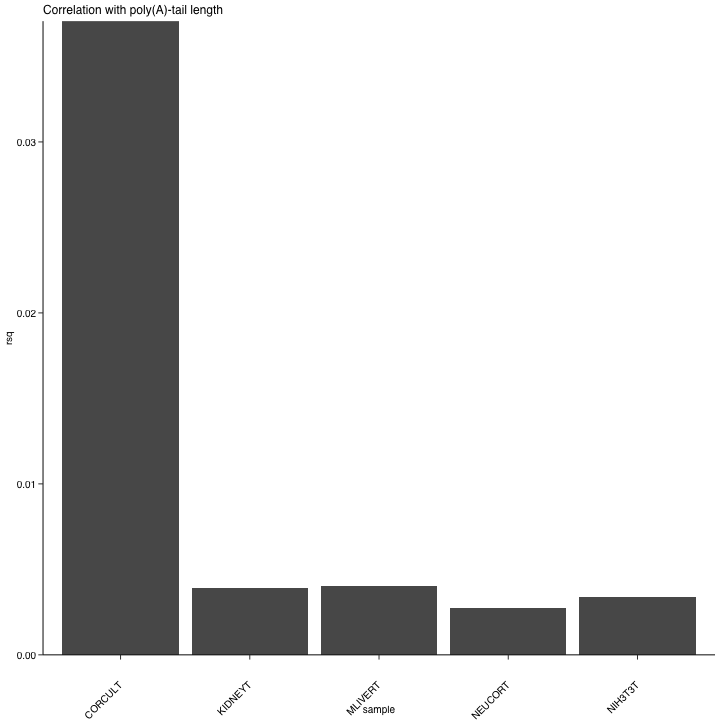

In [28]:
PolyACors <- tibble(
    sample = c(
    "CORCULT",
    "NEUCORT",
    "KIDNEYT",
    "MLIVERT",
    "NIH3T3T"),
    rsq = c(
    cor(CORCULT$TE, CORCULT$polyA_lens)^2,
    cor(NEUCORT$TE, NEUCORT$polyA_lens)^2,
    cor(KIDNEYT$TE, KIDNEYT$polyA_lens)^2,
    cor(MLIVERT$TE, MLIVERT$polyA_lens)^2,
    cor(NIH3T3T$TE, NIH3T3T$polyA_lens)^2))

pPolyACors <- ggplot(PolyACors, aes(x = sample, y = rsq)) +
    ggtitle("Correlation with poly(A)-tail length") + 
    geom_col() + 
    scale_y_continuous(expand = c(0,0)) +
    theme_tim_label() +
    theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1))

pPolyACors
ggsave(pPolyACors, file = "/Users/timeisen/Dropbox (MIT)/BartelLab/Neurons mRNA tails paper/Analysis/FiguresUpdated20210913/ModelFigs/pPolyACors.pdf", width = 2, height = 2)


In [29]:
prettyprint <- function(df){
    coln = as.character(df$Feature)
    coln[which(coln == 'CO_Mega')] = "Codon composition"
    coln[which(coln == 'FP_Mega')] = "5' motifs"
    coln[which(coln == 'FE_Mega')] = "Predicted folding energy"
    coln[which(coln == 'polyA_lens')] = "Poly(A)-tail length"
    coln[which(coln == 'cds_length.log10')] = "CDS length (log10)"
    coln[which(coln == 'uAUG_counts')] = "uAUG counts"
    coln[which(coln == 'log10.mRNA')] = "Expression (log10)"
    coln[which(coln == 'CDS_GC')] = "CDS GC content"
    coln[which(coln == 'CDS_AU')] = "AUUUA counts in CDS"
    coln[which(coln == 'exon_no')] = "Number of exons"
    coln[which(coln == 'ExonJunctionDensity')] = "CDS exon junction density"
    coln[which(coln == 'TpUtrGC')] = "3' UTR GC content"
    coln[which(coln == 'FpUtrGC')] = "5' UTR GC content"
    coln[which(coln == 'TpUtrLength.log10')] = "3' UTR length (log10)"
    coln[which(coln == 'FpUtrLength.log10')] = "5' UTR length (log10)"
    coln[which(coln == 'CAI')] = "CAI"

    df$Feature = coln
#     df$Feature <- factor(df$Feature, levels = arrange(df, desc(Rsq))$Feature)
    return(df)
}

prettyprintVec <- function(coln){
    coln[which(coln == 'CO_Mega')] = "Codon composition"
    coln[which(coln == 'FP_Mega')] = "5' motifs"
    coln[which(coln == 'FE_Mega')] = "Predicted folding energy"
    coln[which(coln == 'polyA_lens')] = "Poly(A)-tail length"
    coln[which(coln == 'cds_length.log10')] = "CDS length (log10)"
    coln[which(coln == 'uAUG_counts')] = "uAUG counts"
    coln[which(coln == 'log10.mRNA')] = "Expression (log10)"
    coln[which(coln == 'CDS_GC')] = "CDS GC content"
    coln[which(coln == 'CDS_AU')] = "AUUUA counts in CDS"
    coln[which(coln == 'exon_no')] = "Number of exons"
    coln[which(coln == 'ExonJunctionDensity')] = "CDS exon junction density"
    coln[which(coln == 'TpUtrGC')] = "3' UTR GC content"
    coln[which(coln == 'FpUtrGC')] = "5' UTR GC content"
    coln[which(coln == 'TpUtrLength.log10')] = "3' UTR length (log10)"
    coln[which(coln == 'FpUtrLength.log10')] = "5' UTR length (log10)"
    coln[which(coln == 'CAI')] = "CAI"

#     df$Feature <- factor(df$Feature, levels = arrange(df, desc(Rsq))$Feature)
    return(coln)
}

In [30]:
print(NEUCORT, width = Inf)

# A tibble: 2,280 x 99
   uAUG_counts `fe_-1window_6` `fe_90%_8` `fe_5'mostTICE_10` `fe_%>80%_10`
         <int>           <dbl>      <dbl>              <dbl>         <dbl>
 1           2       -1.85e- 4 -0.000145           -0.0975          0.211 
 2           7       -1.85e- 4 -0.000185           -0.144           0.135 
 3           3       -3.10e- 5 -0.000122           -1.37            0.116 
 4           1        1.37e-16 -0.000558           -0.0124          0.119 
 5           1       -7.95e- 4 -0.000325           -0.00270         0.115 
 6           4        1.37e-16 -0.000215           -0.0966          0.124 
 7           1        1.37e-16 -0.000507           -0.00638         0.102 
 8           0        1.37e-16 -0.000226           -0.000526        0.193 
 9           1       -1.85e- 4 -0.0000593          -1.57            0.183 
10           1       -2.86e- 4 -0.00120            -0.0619          0.0192
   `fe_sum<=10%_60` fe_min_65 `fe_%>90%_80` `fe_5'most_100` `fe_75%_100`
    

In [31]:
options(repr.plot.width = 4, repr.plot.height = 4)
#Plotting the model.

FULL_DATA <- list(
    CORCULT,
    NEUCORT,
    KIDNEYT,
    MLIVERT,
    NIH3T3T)

DF_NAMES <- c(
    "CORCULT",
    "NEUCORT",
    "KIDNEYT",
    "MLIVERT",
    "NIH3T3T")

DF_NAMES_Readable <- c(
    "Cortical culture",
    "Cortical tissue",
    "Kidney",
    "Liver",
    "NIH 3T3")

MEGA_DF <- list(
    CORCULT_MEGA,
    NEUCORT_MEGA,
    KIDNEYT_MEGA,
    MLIVERT_MEGA,
    NIH3T3T_MEGA)

SubsetFeatureList = NULL
for(idx in 1:5){
# for(idx in 2){ #just NEUCORT_MEGA

    df_name = DF_NAMES[idx]
    CumulativeModel <- GenCumulativeModel(MEGA_DF[[idx]], FULL_DATA[[idx]], df_name, AIC = TRUE)[[1]]
    CumulativeModel <- mutate(CumulativeModel, RsqDiffs = Rsq - lag(Rsq, default = first(Rsq)))
    SubsetFeatureList <- c(SubsetFeatureList, as.character((filter(CumulativeModel, RsqDiffs >= 0.003)$Feature)))
}
SubsetFeatureList <- c(unique(SubsetFeatureList), "polyA_lens")
# original full model
for(idx in 1:5){
# for(idx in 2){ #just NEUCORT_MEGA
    df_name = DF_NAMES[idx]
    ModelList <- GenCumulativeModel(MEGA_DF[[idx]], FULL_DATA[[idx]], df_name, nrep = 100, AIC = FALSE, writeTable = FALSE)
    CumulativeModel <- ModelList[[1]]
    CorrelationTibble <- ModelList[[2]]
    CorrelationTibble <- dplyr::rename(CorrelationTibble, Feature = features, SingleFeatureRsq = Rsq)
    CumulativeModel <- prettyprint(CumulativeModel)
    CorrelationTibble <- prettyprint(CorrelationTibble)
    CumulativeModel <- left_join(CumulativeModel, CorrelationTibble, by = 'Feature') %>%
        mutate(SingleFeatureRsq = format(round(SingleFeatureRsq, 4), nsmall = 4)) %>% #Rounding here
        unite(X_axis_label, Feature, SingleFeatureRsq, signRsq, sep = "     ", remove = FALSE)
    CumulativeModel$X_axis_label <- factor(CumulativeModel$X_axis_label, levels = arrange(CumulativeModel, SingleFeatureRsq)$X_axis_label)
    
    pX <- ggplot(CumulativeModel, aes(x = X_axis_label, y = Rsq)) +
    #      geom_col(position = position_dodge(), color = 'black') + 
        geom_col(position = position_dodge(), width = 0.7, color = 'black', size = 0.4) + 
        geom_errorbar(position = position_dodge(), 
                      aes(ymin = Rsq05th, ymax = Rsq95th), width = 0.5) + 
        geom_text(aes(label = format(round(Rsq,3), nsmall = 3), y = Rsq95th + 0.08), position = position_dodge(width = 0.8), size = 2) +
        scale_x_discrete(name = NULL) +
        scale_y_continuous(expand = c(0,0), limits = c(0, 0.6), name = bquote('Cumulative R'^2)) + 
        theme_tim_label() +
        ggtitle(paste(DF_NAMES_Readable[[idx]], "     n =", nrow(FULL_DATA[[idx]]))) +
        coord_flip()


    ggsave(plot = pX, file = paste0('/Users/timeisen/Dropbox (MIT)/BartelLab/Neurons mRNA tails paper/Analysis/FiguresUpdated20210913/ModelFigs/p4_9_Features_',df_name,".pdf"), width = 4, height = 1.8, useDingbats = FALSE)
}

# AIC model
for(idx in 1:5){
# for(idx in 2){ #just NEUCORT_MEGA
    df_name = DF_NAMES[idx]
    MEGA_MODEL = MEGA_DF[[idx]]
    ModelList <- GenCumulativeModel(dplyr::select(MEGA_MODEL, accession, TE, SubsetFeatureList), FULL_DATA[[idx]], df_name, nrep = 100, AIC = TRUE, writeTable = TRUE)
    print(ModelList)
    CumulativeModel <- ModelList[[1]]
    CorrelationTibble <- ModelList[[2]]
    CorrelationTibble <- dplyr::rename(CorrelationTibble, Feature = features, SingleFeatureRsq = Rsq)
    CumulativeModel <- prettyprint(CumulativeModel)
    CorrelationTibble <- prettyprint(CorrelationTibble)
    CumulativeModel <- left_join(CumulativeModel, CorrelationTibble, by = 'Feature') %>%
        mutate(SingleFeatureRsq = format(round(SingleFeatureRsq, 4), nsmall = 4)) %>% #Rounding here
        unite(X_axis_label, Feature, SingleFeatureRsq, signRsq, sep = "     ", remove = FALSE)
    #I don't know what's going on but I htink that the solution is to make an ordered array of features in this code, then save it to a list that is imported for the correlation tibbles. 
    CumulativeModel$X_axis_label <- factor(CumulativeModel$X_axis_label, levels = arrange(CumulativeModel, desc(Rsq))$X_axis_label)
    
    pX <- ggplot(CumulativeModel, aes(x = X_axis_label, y = Rsq)) +
    #      geom_col(position = position_dodge(), color = 'black') + 
        geom_col(position = position_dodge(), width = 0.7, color = 'black', size = 0.4) + 
        geom_errorbar(position = position_dodge(), 
                      aes(ymin = Rsq05th, ymax = Rsq95th), width = 0.5) + 
        geom_text(aes(label = format(round(Rsq,3), nsmall = 3), y = Rsq95th + 0.08), position = position_dodge(width = 0.8), size = 2) +
        scale_x_discrete(name = NULL) +
        scale_y_continuous(expand = c(0,0), limits = c(0, 0.6), name = bquote('Cumulative R'^2)) + 
        theme_tim_label() +
        ggtitle(paste(DF_NAMES_Readable[[idx]], "     n =", nrow(FULL_DATA[[idx]]))) +
        coord_flip()

    ggsave(plot = pX, file = paste0('/Users/timeisen/Dropbox (MIT)/BartelLab/Neurons mRNA tails paper/Analysis/FiguresUpdated20210913/ModelFigs/p4_9_Features_AIC_',df_name,".pdf"), width = 4, height = 2.25, useDingbats = FALSE)
}


# A tibble: 3,252 x 18
   accession              TE polyA_lens FE_Mega FP_Mega CO_Mega cds_length.log10
   <chr>               <dbl>      <dbl>   <dbl>   <dbl>   <dbl>            <dbl>
 1 ENSMUSG00000032485  1.07        94.7   1.05    1.01    1.57              3.58
 2 ENSMUSG00000047013  1.22       118     0.831   1.58    1.31              3.42
 3 ENSMUSG00000036299  1.67       116.    1.46    1.41    1.21              2.34
 4 ENSMUSG00000032997  0.550      111.    1.17    1.28    1.51              3.26
 5 ENSMUSG00000033805 -0.598      106.    1.54    0.872   0.748             3.03
 6 ENSMUSG00000061451  2.25       132.    1.41    1.61    1.62              3.15
 7 ENSMUSG00000037736  1.43       135.    1.53    1.49    1.42              3.50
 8 ENSMUSG00000041720  2.14       119.    1.33    0.962   1.47              3.79
 9 ENSMUSG00000010277 -1.23       126.    1.02    0.468   0.825             3.83
10 ENSMUSG00000025272  0.553      132.    1.39    1.50    2.14              3.80
   uA

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(all_features)` instead of `all_features` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.

Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order

# A tibble: 2,280 x 18
   accession               TE polyA_lens FE_Mega FP_Mega CO_Mega
   <chr>                <dbl>      <dbl>   <dbl>   <dbl>   <dbl>
 1 ENSMUSG00000047013  0.689       107.    0.868   1.48    0.852
 2 ENSMUSG00000032997  0.676        96.9   0.865   1.34    1.34 
 3 ENSMUSG00000033805  0.717        99.4   1.97    0.955   1.18 
 4 ENSMUSG00000061451  1.75        106.    1.19    1.52    1.23 
 5 ENSMUSG00000041720  0.587       105.    1.56    0.904   1.22 
 6 ENSMUSG00000048142  2.06        119.    1.20    1.24    2.05 
 7 ENSMUSG00000010277 -1.16        107.    1.03    0.502   0.602
 8 ENSMUSG00000025272  0.316       115.    1.81    1.46    1.91 
 9 ENSMUSG00000045573  2.21         82.5   1.94    1.95    1.78 
10 ENSMUSG00000016346 -0.0148       93.1   0.823   1.12    1.14 
   cds_length.log10 uAUG_counts log10.mRNA TpUtrLength.log10 FpUtrLength.log10
              <dbl>       <int>      <dbl>             <dbl>             <dbl>
 1             3.42           2       1

Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”


# A tibble: 6,650 x 18
   accession              TE polyA_lens FE_Mega  FP_Mega CO_Mega
   <chr>               <dbl>      <dbl>   <dbl>    <dbl>   <dbl>
 1 ENSMUSG00000033538 -0.221       89.8  0.177   0.375   -0.376 
 2 ENSMUSG00000041912  0.888      160.  -0.159  -0.210   -0.148 
 3 ENSMUSG00000032011  0.356      109.   0.0984 -0.152   -0.0573
 4 ENSMUSG00000072214  0.254       99.9  0.192  -0.579   -0.211 
 5 ENSMUSG00000028047  0.202       90.3  0.222  -0.0183  -0.421 
 6 ENSMUSG00000017146 -0.855       65.5 -0.287   0.00585 -0.937 
 7 ENSMUSG00000069910  0.701       89.7  0.0422  0.223   -0.694 
 8 ENSMUSG00000063160 -0.286      114.  -0.782  -1.18    -0.357 
 9 ENSMUSG00000047712 -1.47       124.  -0.356  -0.606   -0.225 
10 ENSMUSG00000017550 -1.07       108.   0.0278 -0.0794  -0.779 
   cds_length.log10 uAUG_counts log10.mRNA TpUtrLength.log10 FpUtrLength.log10
              <dbl>       <int>      <dbl>             <dbl>             <dbl>
 1             3.05           0    0.00

Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme orde

# A tibble: 6,210 x 18
   accession             TE polyA_lens FE_Mega FP_Mega CO_Mega cds_length.log10
   <chr>              <dbl>      <dbl>   <dbl>   <dbl>   <dbl>            <dbl>
 1 ENSMUSG00000019132 -5.04      136.   -1.12   -0.619  -0.295             2.84
 2 ENSMUSG00000059995 -4.19      107.   -1.62   -1.49   -0.545             3.03
 3 ENSMUSG00000028416 -4.04       74.7  -0.998  -0.434  -0.857             2.82
 4 ENSMUSG00000052957 -4.03       94.4  -0.424  -1.36   -0.606             3.06
 5 ENSMUSG00000025354 -4.00       70.6   0.111  -1.17   -1.09              3.32
 6 ENSMUSG00000042688 -3.96      104.   -1.48   -0.777  -0.847             3.34
 7 ENSMUSG00000040435 -3.85      131.   -0.168  -1.02   -0.487             3.30
 8 ENSMUSG00000010277 -3.84       66.8  -0.905  -1.58   -1.00              3.83
 9 ENSMUSG00000040943 -3.83      143.   -0.330  -1.38   -1.03              3.76
10 ENSMUSG00000041852 -3.81       51.4  -0.569  -0.773  -1.17              3.78
   uAUG_counts lo

Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme orde

# A tibble: 6,113 x 18
   accession             TE polyA_lens FE_Mega FP_Mega  CO_Mega cds_length.log10
   <chr>              <dbl>      <dbl>   <dbl>   <dbl>    <dbl>            <dbl>
 1 ENSMUST00000019276 -5.61      136.  -1.30   -0.0919  0.356               2.84
 2 ENSMUST00000000756 -4.77       65    0.506   0.299   0.391               2.80
 3 ENSMUST00000186538 -4.70       96.5  0.233  -0.184   0.308               2.99
 4 ENSMUST00000093526 -4.49       75.8  0.532   0.401  -0.389               3.37
 5 ENSMUST00000020706 -3.92       89.3 -0.988  -0.747   0.0768              3.53
 6 ENSMUST00000010421 -3.86       66.8 -0.315  -0.959  -0.195               3.83
 7 ENSMUST00000105651 -3.82      146.   0.419  -0.273  -0.00835             3.28
 8 ENSMUST00000045473 -3.72      112.   0.426   0.342   0.159               3.33
 9 ENSMUST00000060864 -3.63       83   -2.12   -0.211  -0.233               3.28
10 ENSMUST00000060148 -3.55      155.  -0.0357 -0.242  -0.432               3.91
   uA

Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme order statistics used as endpoints”
Warning message in norm.inter(t, alpha):
“extreme orde

[1] "here"
 [1] "CO_Mega"             "FE_Mega"             "FP_Mega"            
 [4] "CAI"                 "log10.mRNA"          "CDS_GC"             
 [7] "TpUtrLength.log10"   "polyA_lens"          "TpUtrGC"            
[10] "cds_length.log10"    "uAUG_counts"         "exon_no"            
[13] "FpUtrLength.log10"   "ExonJunctionDensity" "CDS_AU"             
[16] "FpUtrGC"            
[1] "here"
 [1] "CO_Mega"             "cds_length.log10"    "FE_Mega"            
 [4] "CDS_AU"              "FP_Mega"             "exon_no"            
 [7] "log10.mRNA"          "CAI"                 "CDS_GC"             
[10] "TpUtrLength.log10"   "uAUG_counts"         "FpUtrLength.log10"  
[13] "FpUtrGC"             "TpUtrGC"             "polyA_lens"         
[16] "ExonJunctionDensity"
[1] "here"
 [1] "FE_Mega"             "CO_Mega"             "FP_Mega"            
 [4] "cds_length.log10"    "uAUG_counts"         "FpUtrLength.log10"  
 [7] "CDS_AU"              "exon_no"             "ExonJunctio

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(SubsetFeatureList)` instead of `SubsetFeatureList` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.



# A tibble: 3,252 x 14
   accession              TE FE_Mega TpUtrLength.log10 log10.mRNA exon_no
   <chr>               <dbl>   <dbl>             <dbl>      <dbl>   <dbl>
 1 ENSMUSG00000032485  1.07    1.05               2.16       1.72      22
 2 ENSMUSG00000047013  1.22    0.831              3.54       2         12
 3 ENSMUSG00000036299  1.67    1.46               2.77       2.60       2
 4 ENSMUSG00000032997  0.550   1.17               2.60       2.05       3
 5 ENSMUSG00000033805 -0.598   1.54               2.14       1.81       7
 6 ENSMUSG00000061451  2.25    1.41               3.00       1.93       2
 7 ENSMUSG00000037736  1.43    1.53               3.44       1.92      26
 8 ENSMUSG00000041720  2.14    1.33               2.33       1.78      54
 9 ENSMUSG00000010277 -1.23    1.02               2.78       1.97      39
10 ENSMUSG00000025272  0.553   1.39               2.45       2.29      11
   FP_Mega uAUG_counts CDS_GC FpUtrGC CDS_AU CO_Mega cds_length.log10 polyA_lens
     <db

# A tibble: 6,650 x 14
   accession              TE FE_Mega TpUtrLength.log10 log10.mRNA exon_no
   <chr>               <dbl>   <dbl>             <dbl>      <dbl>   <dbl>
 1 ENSMUSG00000033538 -0.221  0.177               2.33    0.00139       8
 2 ENSMUSG00000041912  0.888 -0.159               2.87    0.00166      12
 3 ENSMUSG00000032011  0.356  0.0984              3.05    0.00314       3
 4 ENSMUSG00000072214  0.254  0.192               2.96    0.00708      12
 5 ENSMUSG00000028047  0.202  0.222               2.40    0.00731      23
 6 ENSMUSG00000017146 -0.855 -0.287               3.00    0.00913      22
 7 ENSMUSG00000069910  0.701  0.0422              2.71    0.0152       11
 8 ENSMUSG00000063160 -0.286 -0.782               2.86    0.0175       10
 9 ENSMUSG00000047712 -1.47  -0.356               3.38    0.0175        8
10 ENSMUSG00000017550 -1.07   0.0278              3.12    0.0186       23
    FP_Mega uAUG_counts CDS_GC FpUtrGC CDS_AU CO_Mega cds_length.log10
      <dbl>       

# A tibble: 6,113 x 14
   accession             TE FE_Mega TpUtrLength.log10 log10.mRNA exon_no FP_Mega
   <chr>              <dbl>   <dbl>             <dbl>      <dbl>   <dbl>   <dbl>
 1 ENSMUST00000019276 -5.61 -1.30                2.11      1.96        5 -0.0919
 2 ENSMUST00000000756 -4.77  0.506               1.58      1.52        5  0.299 
 3 ENSMUST00000186538 -4.70  0.233               2.88      1.12        1 -0.184 
 4 ENSMUST00000093526 -4.49  0.532               2.95      1.42       14  0.401 
 5 ENSMUST00000020706 -3.92 -0.988               3.91      1.03       20 -0.747 
 6 ENSMUST00000010421 -3.86 -0.315               2.78      1.88       39 -0.959 
 7 ENSMUST00000105651 -3.82  0.419               3.23      0.988       5 -0.273 
 8 ENSMUST00000045473 -3.72  0.426               3.08      1.22        5  0.342 
 9 ENSMUST00000060864 -3.63 -2.12                2.67      1.13       10 -0.211 
10 ENSMUST00000060148 -3.55 -0.0357              2.69      0.692       8 -0.242 
   uA

Corplots below:

In [32]:
# summary(lm(TE ~ ., dplyr::select(NIH3T3T, -accession)))
source("https://raw.githubusercontent.com/dorianps/corrplot2/master/corrplot2.R")
FULL_DATA <- list(
    CORCULT,
    NEUCORT,
    KIDNEYT,
    MLIVERT,
    NIH3T3T)

DF_NAMES <- c(
    "CORCULT",
    "NEUCORT",
    "KIDNEYT",
    "MLIVERT",
    "NIH3T3T")

DF_NAMES_Readable <- c(
    "Cortical culture",
    "Cortical tissue",
    "Kidney",
    "Liver",
    "NIH 3T3")

MEGA_DF <- list(
    CORCULT_MEGA,
    NEUCORT_MEGA,
    KIDNEYT_MEGA,
    MLIVERT_MEGA,
    NIH3T3T_MEGA)

for(idx in 1:5){
    df_name = DF_NAMES[idx]
    MEGA_MODEL = MEGA_DF[[idx]]
    #FEATURES needs to be a list here imported from the previous code block in the correct order. 
    DF <- dplyr::select(MEGA_MODEL, accession, TE, features)
    all_cors <- cor(dplyr::select(DF, -accession, -TE), method = 'pearson') #removing TE for this analysis
    print(all_cors)
    all_cors <- all_cors[rev(features),rev(features)]
    colnames(all_cors) <- prettyprintVec(colnames(all_cors))
    rownames(all_cors) <- prettyprintVec(rownames(all_cors))

    pdf(file = paste0('/Users/timeisen/Dropbox (MIT)/BartelLab/Neurons mRNA tails paper/Analysis/FiguresUpdated20210913/ModelFigs/pCorPlot_v4_',df_name,".pdf"), width = 3, height = 3)
    corrplot2(all_cors,
        addCoef.col = "black",
        addCoef.font = 1, #not bold
        method="color",
        tl.cex = 0.5,
        cl.cex = 0.5,
        tl.col = "black", #label color
        addCoef.cex = 0.4,
#         number.cex = 0.5,
#         title = df_name,
        type = 'upper')    
    dev.off()
}


ERROR: Error: Can't subset columns that don't exist.
[31m✖[39m Column `features` doesn't exist.
